CIFAR10

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

In [5]:
from fastai.conv_learner import *
PATH = Path("C:/input/cifar10/cifar_class")

C:\Users\ac32\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
bs=64
sz=32

In [9]:
tfms = tfms_from_model(resnet18, sz, aug_tfms=[RandomFlip()], pad=sz//8)
#data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train.csv', tfms=tfms, bs=bs)
data = ImageClassifierData.from_paths(str(PATH), val_name='test', tfms=tfms, bs=bs)

In [10]:
learn = ConvLearner.pretrained(resnet18, data)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\ac32/.torch\models\resnet18-5c106cde.pth
100%|████████████████████████| 46827520/46827520 [00:02<00:00, 23042735.13it/s]


In [11]:
lr=1e-2; wd=1e-5

In [ ]:
learn.lr_find()
learn.sched.plot()

In [21]:
class SimpleConv(nn.Module):
    def __init__(self,ic,oc,ks=3,drop=0.2,bn=True):
        super().__init__()
        self.conv = nn.Conv2d(ic,oc,ks,padding=(ks-1)//2)
        self.bn = nn.BatchNorm2d(oc,momentum=0.05) if bn else None
        #self.drop = nn.Dropout(drop,inplace=True)
        self.drop = nn.Dropout(drop,inplace=False)
        self.act = nn.ReLU(True)
    
    def forward(self,x):
        x = self.conv(x)
        if self.bn: x = self.bn(x)
        return self.drop(self.act(x)) 

In [22]:
net = nn.Sequential(
    SimpleConv(3, 64),
    SimpleConv(64, 128),
    SimpleConv(128, 128),
    SimpleConv(128, 128),
    nn.MaxPool2d(2),
    SimpleConv(128, 128),
    SimpleConv(128, 128),
    SimpleConv(128, 256),
    nn.MaxPool2d(2),
    SimpleConv(256, 256),
    SimpleConv(256, 256),
    nn.MaxPool2d(2),
    SimpleConv(256, 512),
    SimpleConv(512, 2048, ks=1, bn=False),
    SimpleConv(2048, 256, ks=1, bn=False),
    nn.MaxPool2d(2),
    SimpleConv(256, 256, bn=False, drop=0),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(256, 10)
)

In [23]:
#bm = BasicModel(net.cuda(), name='simplenet')
bm = BasicModel(net, name='simplenet')
learn = ConvLearner(data, bm)
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.unfreeze()
learn.metrics=[accuracy]
lr = 1e-3
wd = 5e-3

 67%|██████████████████▊         | 526/782 [1:24:26<41:05,  9.63s/it, loss=6.8]

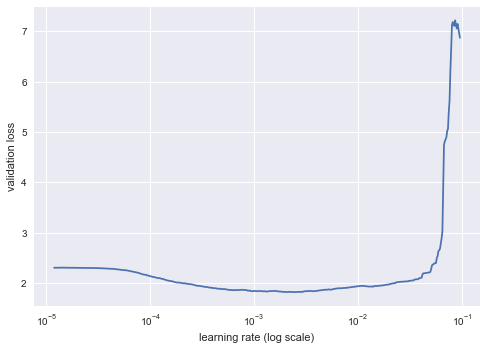

In [24]:
#sgd mom
learn.lr_find()
learn.sched.plot()

In [18]:
%time
learn.fit(lr, 1, wds=wd, cycle_len=5, use_clr=(32,10))

In [ ]:
bm.get_layer_groups()

In [ ]:
learn.save('0')

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2, wds=wd)